## 卷积神经网络简洁实现

例子: MNIST数据集手写数字识别

### 导库

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils import data
from matplotlib import pyplot as plt

### 加载数据集

In [2]:
def load_data_mnist(batch_size, resize=None):
    """下载MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=0),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=0))

### 定义网络结构

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, padding='same'),
    nn.MaxPool2d(kernel_size=2, padding=0, stride=2),
    nn.Conv2d(32, 64, kernel_size=5, padding='same'),
    nn.MaxPool2d(kernel_size=2, padding=0, stride=2),
    nn.Flatten(),
    nn.Linear(3136, 1024),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, 10))

net = net.cuda()

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=3136, out_features=1024, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=1024, out_features=10, bias=True)
)

### 精确度统计

In [4]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = (y_hat.type(y.dtype) == y)
    return float(cmp.type(y.dtype).sum())

In [5]:
class Accumulator:
    """在 n 个变量上进行累加的一个累加器"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        selfdata = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [6]:
def evaluate_accuracy(net, data_iter):
    """计算在特定数据集上的模型精度"""
    metric = Accumulator(2)
    for X, y in data_iter:
        X, y = X.cuda(), y.cuda()
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1] # 成功预测的数 / 预测总数

### 作图函数

In [7]:
def draw(title, xlabel, ylabel, x, y):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y, 'r')
    plt.show()

### 训练函数

In [8]:
def train_epoch_CNN(net, train_iter, loss, updater):
    """训练模型的一个迭代周期""" 
    # 将模型调整成训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练精准度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        X, y = X.cuda(), y.cuda()
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [9]:
def train_CNN(net, train_iter, test_iter, loss, num_epochs, updater):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch_CNN(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

    epochlist = range(1, num_epochs + 1)
    draw('train_loss_list', 'epochs', 'loss', epochlist, train_loss_list)
    draw('train_acc_list', 'epochs', 'acc', epochlist, train_acc_list)
    draw('test_acc_list', 'epochs', 'acc', epochlist, test_acc_list)

    print(f'最终训练损失: {train_loss_list[-1]}')
    print(f'最终训练精度: {train_acc_list[-1]}')
    print(f'最终测试精度: {test_acc_list[-1]}')

### 开始训练

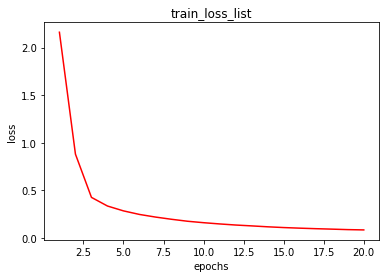

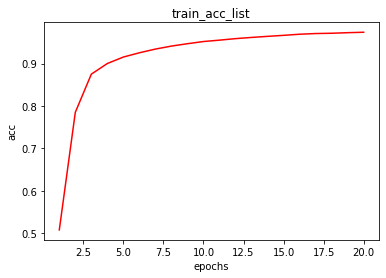

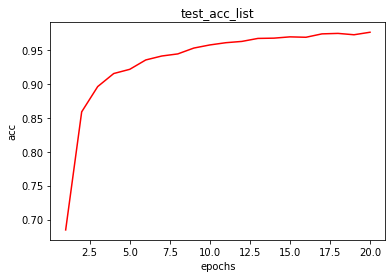

最终训练损失: 0.0863147777557373
最终训练精度: 0.97385
最终测试精度: 0.9759


In [10]:
batch_size, lr, num_epochs = 256, 0.01, 20
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = load_data_mnist(batch_size)
train_CNN(net, train_iter, test_iter, loss, num_epochs, trainer)